In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
!pip install tensorflow
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# **Get The Kaggle Dataset**

[Dataset Link](https://www.kaggle.com/competitions/dog-breed-identification/dataa)

Get the Kaggle API KEY as mentioned in the [steps](https://www.kaggle.com/docs/api#authentication)

In [2]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"sahiljain28","key":"3ff1d6b61668ef1f4e33eb8738909466"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dog-breed-identification
!unzip /content/dog-breed-identification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: train/83fad0718581a696132c96c166472627.jpg  
  inflating: train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  inflating: train/8410ced9ebc1759a7ebce5c42bfb5222.jpg  
  inflating: train/84

**Loading The Dataset**

In [4]:
df1=pd.read_csv('/content/labels.csv')
df1.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [5]:
train_dir = '/content/train'
test_dir ='/content/test'
BATCH_SIZE = 32
image_size= (331,331)
shape=(331,331,3)

**Appending .jpg to the id's in the id column**

In [6]:
def append_ext(fn):
    return fn+".jpg"
traindf = pd.read_csv('/content/labels.csv',dtype=str)
traindf["id"] = traindf["id"].apply(append_ext)
traindf.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


# **Preprocess The Data**

**Create Train and Test data**

In [7]:
train_datagen = ImageDataGenerator( rescale=1./255.,
                                  horizontal_flip = True,
                                  #Setting validation split to 2%
                                  validation_split=0.02
)

#train data from train folder
train_generator=train_datagen.flow_from_dataframe(
dataframe=traindf,
directory=train_dir,
x_col="id",
y_col="breed",
subset="training",
batch_size=BATCH_SIZE,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=image_size,
color_mode="rgb"
)

#test data from test folder
test_generator=train_datagen.flow_from_dataframe(
dataframe=traindf,
directory=train_dir,
x_col="id",
y_col="breed",
subset="validation",
batch_size=BATCH_SIZE,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=image_size,
color_mode="rgb")




Found 10018 validated image filenames belonging to 120 classes.
Found 204 validated image filenames belonging to 120 classes.


# **Create A NASNetLarge model**

In [8]:
pretrained_model = tf.keras.applications.NASNetLarge(
        weights='imagenet',
        include_top=False ,
        input_shape=shape
    )
pretrained_model.trainable = False

model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        #tf.keras.layers.Dense(256, activation='relu'),
        #tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(120, activation='softmax')
])

#opt = tf.keras.optimizers.Adam(learning_rate=0.001)
opt=tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9)
model.compile(optimizer = opt ,
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

343610240/343610240 [==============================] - 9s 0us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 11, 11, 4032)      84916818  
                                                                 
 global_average_pooling2d (  (None, 4032)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 120)               483960    
                                                                 
Total params: 85400778 (325.78 MB)
Trainable params: 483960 (1.85 MB)
Non-trainable params: 84916818 (323.93 MB)
_________________________________________________________________


# **Train the Model**

In [ ]:
epochs = 10

early = tf.keras.callbacks.EarlyStopping( patience=2,
                                          min_delta=0.001,
                                          restore_best_weights=True)

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = test_generator.n//test_generator.batch_size
history2 = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=test_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks=[early],)

Epoch 1/10
313/313 [==============================] - 335s 986ms/step - loss: 1.1546 - accuracy: 0.8452 - val_loss: 0.3354 - val_accuracy: 0.9271
Epoch 2/10
185/313 [================>.............] - ETA: 2:00 - loss: 0.2623 - accuracy: 0.9383

# **Loss and Accuracy Curves**

<ipython-input-19-69b6d34d0670>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


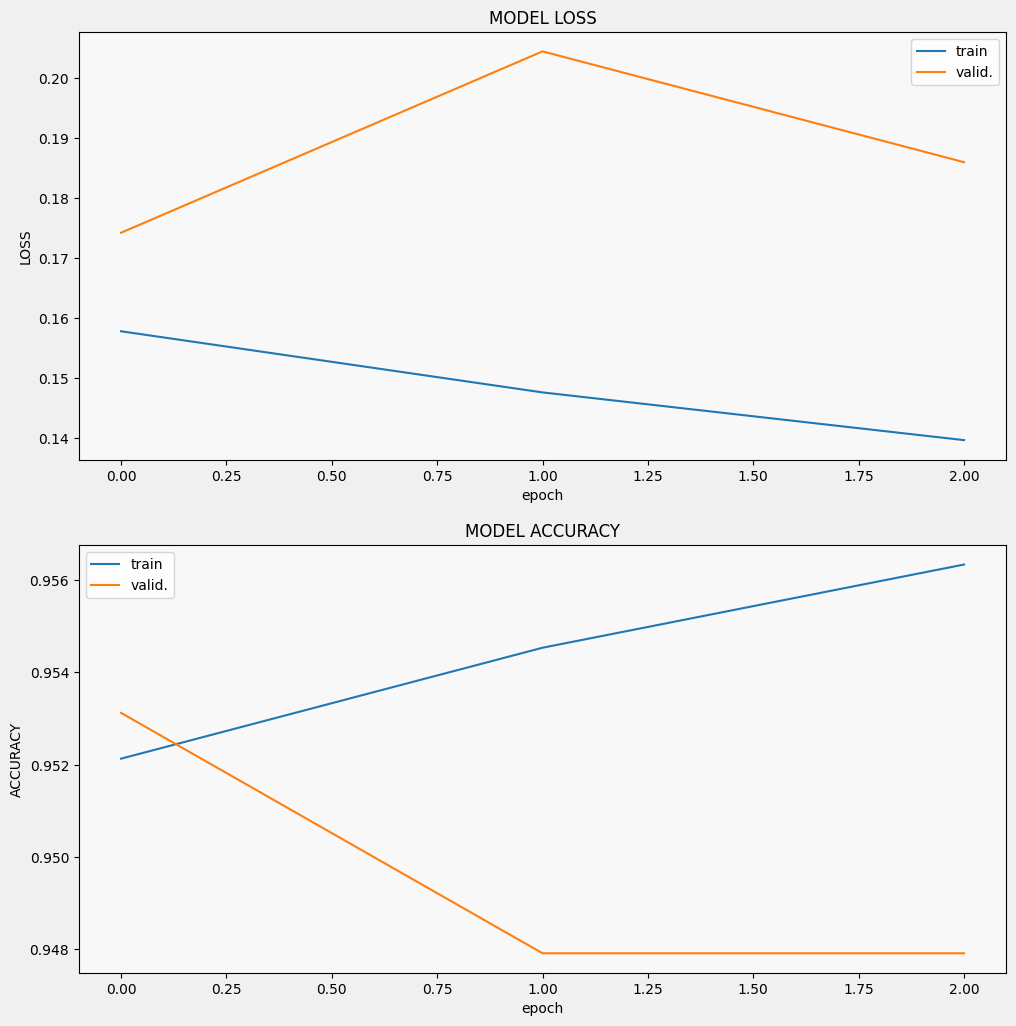

In [ ]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('MODEL '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

display_training_curves(
    history2.history['loss'],
    history2.history['val_loss'],
    'LOSS',
    211,
)

display_training_curves(
    history2.history['accuracy'],
    history2.history['val_accuracy'],
    'ACCURACY',
    212,
)


# **Test the Accuracy**

In [ ]:
score = model.evaluate(test_generator,batch_size=32)
print("Accuracy: {:.2f}%".format(score[1] * 100))
print("Loss: ",score[0])

7/7 [==============================] - 8s 1s/step - loss: 0.2078 - accuracy: 0.9510
Accuracy: 95.10%
Loss:  0.20782795548439026


# **Save The Model**

**Save The Model**

Refer the [docs](https://www.tensorflow.org/guide/keras/save_and_serialize) from the Tensorflow

In [ ]:
!mkdir '/content/model'
model.save('/content/model')

# **Model To TFLITE**

**Using [Python API](https://www.tensorflow.org/lite/models/convert/convert_models) (Recommended Approach) we convert the Keras Model to TLITE**

This TFLITE model will be deployed to our [Android App](https://github.com/generic-matrix/android-face-mask-detection)

In [ ]:
!mkdir '/content/tflite'
saved_model_dir = '/content/model'
tflite_model_path = '/content/tflite/model.tflite'
# Convert the model
# path to the SavedModel directory
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

# Save the model.
with open(tflite_model_path, 'wb') as f:
  f.write(tflite_model)

**Download The Files**

In [ ]:
# Download the tflite Model
from google.colab import files
files.download(tflite_model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import json

#class names to json
class_names=train_generator.class_indices
f = open("classes.json", "a")
f.write(json.dumps(class_names))
f.close()

Example Way To Parse

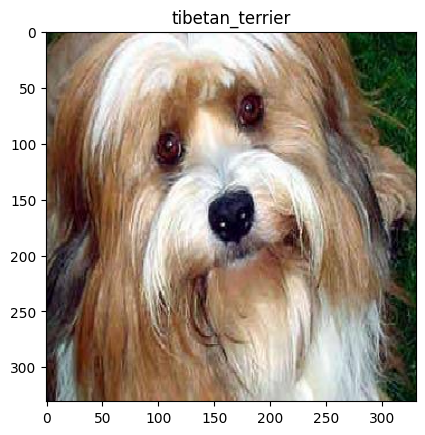

In [ ]:
class_names=train_generator.class_indices

new_dict={}
for key, value in class_names.items():
    new_dict[value]=key

for _ in range(len(train_generator.filenames)):
     image, label = train_generator.next()
     index = list(label[0]).index(1)
     # display the image from the iterator
     plt.imshow(image[0])
     label_name=new_dict[index] # note you are only showing the first image of the batch
     plt.title(label_name)
     plt.show()
     break

In [ ]:
new_dict

{0: 'affenpinscher',
 1: 'afghan_hound',
 2: 'african_hunting_dog',
 3: 'airedale',
 4: 'american_staffordshire_terrier',
 5: 'appenzeller',
 6: 'australian_terrier',
 7: 'basenji',
 8: 'basset',
 9: 'beagle',
 10: 'bedlington_terrier',
 11: 'bernese_mountain_dog',
 12: 'black-and-tan_coonhound',
 13: 'blenheim_spaniel',
 14: 'bloodhound',
 15: 'bluetick',
 16: 'border_collie',
 17: 'border_terrier',
 18: 'borzoi',
 19: 'boston_bull',
 20: 'bouvier_des_flandres',
 21: 'boxer',
 22: 'brabancon_griffon',
 23: 'briard',
 24: 'brittany_spaniel',
 25: 'bull_mastiff',
 26: 'cairn',
 27: 'cardigan',
 28: 'chesapeake_bay_retriever',
 29: 'chihuahua',
 30: 'chow',
 31: 'clumber',
 32: 'cocker_spaniel',
 33: 'collie',
 34: 'curly-coated_retriever',
 35: 'dandie_dinmont',
 36: 'dhole',
 37: 'dingo',
 38: 'doberman',
 39: 'english_foxhound',
 40: 'english_setter',
 41: 'english_springer',
 42: 'entlebucher',
 43: 'eskimo_dog',
 44: 'flat-coated_retriever',
 45: 'french_bulldog',
 46: 'german_sheph